In [1]:
from basiss.pile_of_code import *

## Sample load 

In [2]:
with open('../pymc_model/data/newdata_case2_saved.pkl', 'rb') as file:
    saved_lists = pkl.load(file)
imm_sample_list = saved_lists['imm_sample_list']
exp_sample_list = saved_lists['exp_sample_list']
mut_sample_list = saved_lists['mut_sample_list']


### Loading IHC masks 

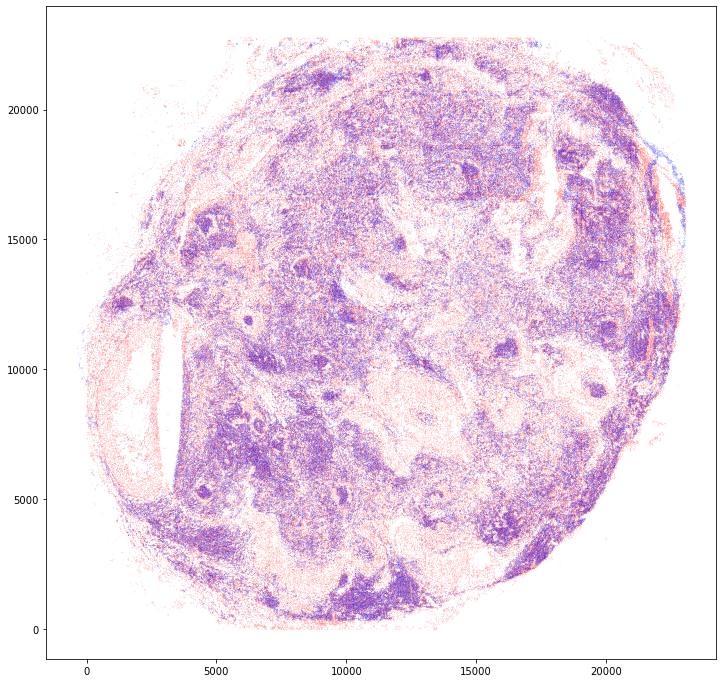

In [3]:
#Additional infomation about cell types 

Mut3068_25_panCK = pd.read_csv('../ultra_hd_segmentation/masks_corrected/Mut3068-25 panCK_aligned.csv')
Imm3068_25_CD45 = pd.read_csv('../ultra_hd_segmentation/masks_corrected/Imm3068-25 CD45_aligned.csv')


plt.figure(figsize=(12,12))
plt.scatter(mut_sample_list[2].cellpos[:,0], mut_sample_list[2].cellpos[:,1], s=0.001, color='red')
#plt.scatter(mut_sample_list[2].cellpos[np.array(Mut3068_25_panCK.iloc[:,0]),0],
#            mut_sample_list[2].cellpos[np.array(Mut3068_25_panCK.iloc[:,0]),1], s=0.001, color='red')
plt.scatter(imm_sample_list[2].cellpos[np.array(Imm3068_25_CD45.iloc[:,0]),0],
            imm_sample_list[2].cellpos[np.array(Imm3068_25_CD45.iloc[:,0]),1], s=0.001, color='blue')

plt.gca().set_aspect('equal')

## Construct model data

#### Loading genotype matrix (tree)

The genotype matrix $\mathbf{G}$ contains the number of each allelic copy in each clone $s$. $\mathbf{G}$ is a matrix representation of the underlying phylogenetic tree and provides the instructions of the allelic configuration in each branch of the tree.

In [4]:
genes_to_drop= []

tree = pd.read_csv('./data/PD14780_tree.csv',index_col=0)

In [5]:
#adding 2 wt classes
M = np.array(tree.iloc[:-1])
M_wt = np.array(tree.iloc[-1])
n_wt=2
M = np.concatenate([M] + n_wt * [M_wt[None,:]],axis=0)

#### Calculating VAF data from WGS  

WGS data contains information of the mutated allele frequencies on the whole slide. We can use this data to better regularise the model

We construct a Beta pseudo-likelihood of $\mathbf{VAF}^{\text{BaSISS}}$ with $\alpha$ and $\beta$ parameters proprtional to the number of mutated and wild-type reads in WGS experiment. We use parameter $u=5$ to inflate uncertainty in WGS data as it comes from proximal but not exactly the same slide we are observing in BaSISS experiment. 

$$\text{VAF}^{\text{BaSISS}}_m \sim \mathrm{Beta}(\alpha=\text{WGS}^\text{mut}_m / u + 1, \alpha=\text{WGS}^\text{wt}_m / u + 1)$$

In [6]:
wgs_data = pd.read_csv('../pymc_model/data/PD14780_genome_data_jan_2020.csv')
wgs_data = wgs_data[np.logical_not(np.isin(wgs_data.Gene,genes_to_drop))]
wgs_names = np.array(wgs_data.Gene)
wgs_wt = []
wgs_mut = []
for i, s in enumerate('ade'):
    wgs_mut.append(np.array(wgs_data[f'dis_MtAll_PD14780{s}']))
    wgs_wt.append(np.array(wgs_data[f'dis_depth_PD14780{s}'] - wgs_data[f'dis_MtAll_PD14780{s}']))

#wgs_wt.append(np.array([M[:,np.where(tree.columns == gene + 'wt')[0][0]].mean(axis=0) for gene in wgs_names]))
#wgs_mut.append(np.array([M[:,np.where(tree.columns == gene + 'mut')[0][0]].mean(axis=0) for gene in wgs_names]))
wgs_wt.append(wgs_wt[0]/5)
wgs_mut.append(wgs_mut[0]/5)
wgs_wt.append(wgs_wt[0]/5)
wgs_mut.append(wgs_mut[0]/5)

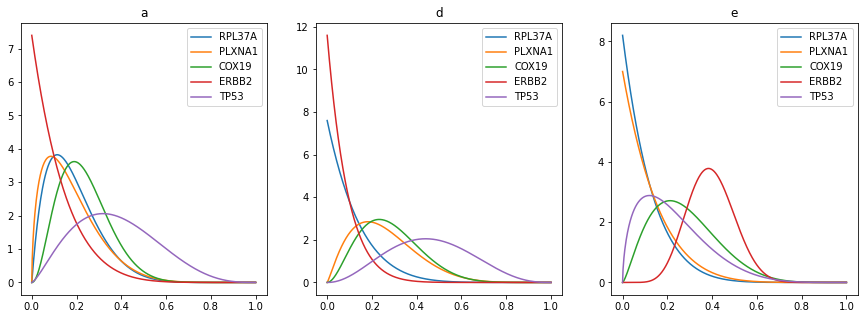

In [7]:
plt.figure(figsize=(15,5))
for s in range(3):
    plt.subplot(1,3,s+1)
    for i in range(len(wgs_names)):
        plt.plot(np.linspace(0.0,1,500), stats.beta(wgs_mut[s][i]/5 + 1, wgs_wt[s][i]/5+1).pdf(np.linspace(0.0,1,500)), label=wgs_names[i])
        #plt.ylim(0,100)
        plt.legend()
        plt.rcParams['figure.facecolor'] = 'w'
    plt.title('ade'[s])

#### Loadin BaSISS data

The counts of all probes can be represented by a three dimensional array $\mathbf{D} \in \mathbb{N}^{|a|\times |x| \times |y|}$, where $a$ refers to the allele and $x$ and $y$ are course grained coordinates on a regular grid of dimensions $|x| \times |y|$. The grid size was chosen to be  108.8$\mu$m considering a trade-off between data sparsity, precision and computational cost.

In [8]:
def mask_infisble(mut_sample_list, scale, probability=0.6, critical_genes=False, plot=False):
    mask = []
    for i in range(len(mut_sample_list)):
        mut_sample_list[i].data_to_grid(scale_factor=scale, probability=0.6)
        t = np.array([s for s in mut_sample_list[i].gene_grid.values()])[:-3].sum(0)
        mask_infisiable = mut_sample_list[i].gene_grid['infeasible']/t < 0.1
        mask_infisiable *= mut_sample_list[i].cell_grid > 5
        
        if critical_genes:
            if i == 0:
                mask_infisiable *= mut_sample_list[i].gene_grid["PTEN2mut"] + mut_sample_list[i].gene_grid["LRP1Bmut"] + mut_sample_list[i].gene_grid["NOB1wt"] <= 3 

        if plot:
            plt.figure(figsize=(8,4))
            plt.imshow(mask_infisiable.T[::-1,:])
            
        mask.append(mask_infisiable.flatten())
            
    return mask

def generate_data4model(samples_list, genes, M, n_aug=1, unified_names=None):
    n_samples = len(samples_list)
    n_genes = len(genes)
    if not unified_names is None:
        iss_data = [np.transpose(np.array([samples_list[i].gene_grid[unified_name1[i][k]] for k in genes]), [1,2,0]).reshape(-1, n_genes) for i in range(n_samples)]

    tiles_axes = [samples_list[i].tile_axis for i in range(n_samples)]

    cells_counts = [samples_list[i].cell_grid.flatten() for i in range(n_samples)]
    sample_dims = [(int(tiles_axes[i][0][-1]+1), int(tiles_axes[i][1][-1]+1)) for i in range(n_samples)]
    n_factors = M.shape[0]
    n_aug=1
    
    return {'iss_data': iss_data, 'tiles_axes': tiles_axes, 'cells_counts': cells_counts, 'sample_dims': sample_dims,
            'n_factors': n_factors, 'n_aug': n_aug, 'tree_matrix':M, 'n_samples': n_samples, 'n_genes': n_genes, 'genes': genes}


100%|██████████| 21/21 [00:00<00:00, 35.45it/s]


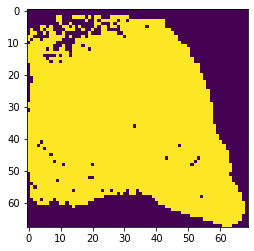

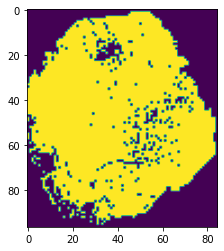

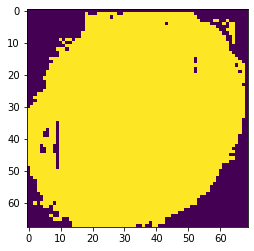

In [9]:
unified_name1 = [{np.unique(mut_sample_list[2].data['Gene'])[i]: np.unique(mut_sample_list[j].data['Gene'])[i]
                  for i in range(len(np.unique(mut_sample_list[2].data['Gene'])))} for j in range(3)]


scale = 3

mut_mask = mask_infisble(mut_sample_list, scale, probability=0.6, plot=True)
data4model = generate_data4model(samples_list=mut_sample_list, genes=tree.columns, M=M, n_aug=1, unified_names=unified_name1)

n_samples = data4model['n_samples']
n_genes = data4model['n_genes']
iss_data = data4model['iss_data']
tiles_axes = data4model['tiles_axes']
cells_counts = data4model['cells_counts']
sample_dims = data4model['sample_dims']
n_factors = data4model['n_factors']
n_aug = data4model['n_aug']

mask = mut_mask

### Calculating CD45+ (immune) cell fractions

IHC data reveals part of cell type heterogeneity. In our study we mainly worked with CD45 IHC staining which indicates location of lymphocytes. As we know that none of the lymphocytes should contribute to cancer clone weights, we could further regularise clone weights. 

We use a Beta pseudo-likelihood of $\mathbf{CellFrac}$ distribution with $\alpha$ and $\beta$ parameters equal to cell counts of clear and IHC stained nuclei on the slide.

$$
\mathbf{CellFrac}_{x,y} \sim \mathrm{Beta}(\alpha=\text{IHC}^\text{ -}_{x,y} + 1, \alpha=\text{IHC}^\text{ +}_{x,y} + 1)
$$

In [10]:
#add CD45 data
def to_grid(x_raw, y_raw, grid_params, img_size):
    
    arr = np.zeros((grid_params[0], grid_params[1]))
    x_step = img_size[0] / (mut_sample_list[2].grid_params[0]-1)
    y_step = img_size[1] / (mut_sample_list[2].grid_params[1]-1)
    tiles = np.array([(x_raw//x_step).astype(int),
                        (y_raw//y_step).astype(int)]).T
    k_id, v = np.unique(tiles, return_counts=True, axis=0)
    for i in range(len(v)):
        arr[tuple(k_id[i,:])] = v[i]
        
    return arr

In [11]:
cells_counts_CD45 = to_grid(x_raw=imm_sample_list[2].cellpos[np.array(Imm3068_25_CD45.iloc[:,0]),0],
                    y_raw=imm_sample_list[2].cellpos[np.array(Imm3068_25_CD45.iloc[:,0]),1], 
                    grid_params=mut_sample_list[2].grid_params,
                    img_size=mut_sample_list[2].spatial_dims).flatten()

cells_counts_complemet = to_grid(x_raw=imm_sample_list[2].cellpos[:,0],
                    y_raw=imm_sample_list[2].cellpos[:,1], 
                    grid_params=mut_sample_list[2].grid_params,
                    img_size=mut_sample_list[2].spatial_dims).flatten()

imm_sample_list[2].data_to_grid(scale_factor=scale, probability=0.6)
mut_mask[2] = mut_mask[2] * (np.abs(mut_sample_list[2].cell_grid - imm_sample_list[2].cell_grid) / mut_sample_list[2].cell_grid < 0.5).flatten()

100%|██████████| 66/66 [00:00<00:00, 67.01it/s]


## Define and run the model

The essential idea is that the expected number of BaSISS signals is decomposed into maps of $|s|$ distinct clones $s$ $\mathbf{M} \in \mathbb{R}^{|s|\times |x| \times |y|}$ each with a distinct genotype $\mathbf{G} \in \mathbb{N}^{|a|\times |s|}$,

$$\mathbb{E}[\mathbf{D}] \approx \mathbf{G} \times \mathbf{M} = \sum_{s \in \text{subclones}} \mathbf{G}_{\cdot, s} \mathbf{M}_{s, \cdot, \cdot}$$

Accounting for sources of noise, this equation for the expected number of BaSISS signals becomes:


$$\boldsymbol{\mu}_{a, x,y} = \underbrace{\boldsymbol{\nu}_{x,y}}_{\text{cell density}} \cdot \overbrace{\boldsymbol{\iota}_a}^{ {\text{detection rate}}} \cdot \underbrace{\sum_{a'} \boldsymbol{\tau}_{a,a'}}_{\text{probe confusion}} \sum_s  \overbrace{\boldsymbol{\gamma}_{s,a}}^{ {\text{clone-specific expression}}} \underbrace{\mathbf{G}_{a,s} \mathbf{M}_{s,x,y}}_{\text{clone contribution}} + \overbrace{\boldsymbol{\beta}_a}^{ {\text{background}}}$$

For more detials see Suppl. Methods 

In [ ]:
with pm.Model() as model_hierarchical_errosion:
    
    xi = [pm.Gamma('xi_{}'.format(s), mu=0.5, sigma=1, shape=n_genes) for s in range(n_samples)]
    r_mu = pm.Gamma('r', mu=0.5, sigma=1, shape=n_genes)
    r_de = [pm.Lognormal('r_de_{}'.format(s), mu=0, sigma=0.05, shape=n_genes) for s in range(n_samples)]
    r = [r_mu * r_de_i for r_de_i in r_de]
    
    cov_func1_f = [[pm.gp.cov.ExpQuad(1, ls=1.7*np.sqrt(scale)) for i in range(n_factors-1 + n_aug)] for s in range(n_samples)]
    cov_func2_f = [[pm.gp.cov.ExpQuad(1, ls=1.7*np.sqrt(scale)) for i in range(n_factors-1 + n_aug)] for s in range(n_samples)]

    gp_f = [[pm.gp.LatentKron(cov_funcs=[cov_func1_f[s][i], cov_func2_f[s][i]]) for i in range(n_factors - 1 + n_aug)] for s in range(n_samples)] 
    f_f = [[gp_f[s][i].prior(name, Xs=tiles_axes[s]) for i, name in enumerate(['f_f_{}_{}'.format(i, s) for i in range(n_factors - 1 + n_aug)])] for s in range(n_samples)]
    f_f = [f_f[s] + [np.ones(len(cells_counts[s]))*(-2.3)] for s in range(n_samples)]
    F_matrix = [tt.stack(f_f[s], axis=1) for s in range(n_samples)]

    F = [pm.Deterministic('F_{}'.format(s), tt.exp(F_matrix[s] / 2) / tt.exp(F_matrix[s] / 2).sum(axis=1)[:,None]) for s in range(n_samples)]

    lm_n = [pm.Gamma('lm_n_{}'.format(s), mu=50, sigma=100, shape=len(cells_counts[s])) for s in range(n_samples)]
    pois_n = [pm.Poisson('n_{}'.format(s), lm_n[s], observed=cells_counts[s]) for s in range(n_samples)]  
    E0 = 4 ## ie 1 for most loci; 4 for amps
    E = [E0 * pm.Beta(f'E_{s}',0.01,1, shape=(n_aug, n_genes)) for s in range(n_samples)] #(M - M[-1,:]).max(0) 
    
    M_de = pm.Lognormal('M_de', mu=0.0, sigma=0.05, shape=M.shape)    
    M_de = tt.pow(M_de, tt.concatenate([tt.ones((n_factors-n_wt,1)), 2 * tt.ones((n_wt,1))],axis=0))
    M_aug = M * M_de
    M_aug_de = [pm.Lognormal(f'M_aug_{s}', mu=0.0, sigma=0.05, shape=(n_factors, n_genes)) for s in range(n_samples)]

    
    theta_pure = [pm.Deterministic('theta_{}'.format(s), tt.dot(F[s], tt.concatenate([M,E[s]]))) for s in range(n_samples)]
    
    #M_aug = tt.concatenate([M_aug[:n_factors-1,:], M_aug[None,-1,:]], axis=0)
    theta = [pm.Deterministic('theta_mod_{}'.format(s), tt.dot(F[s], tt.concatenate([M_aug * M_aug_de[s] , E[s]], axis=0))) for s in range(n_samples)] #* M_aug_de[s]

   
    z = 1 - pm.Beta('z', 1, 25, shape=n_genes)/4 ## ie ~1% probe confusion
    
    confusion_matrix = tt.eye(n_genes)

    for i in range(n_genes):
        for j in range(n_genes):
            if tree.columns[i].endswith('mut') and tree.columns[j].endswith('mut') and tree.columns[i][:-3] == tree.columns[j][:-3]:
                confusion_matrix = tt.set_subtensor(confusion_matrix[i, j], z[i])
    
            if tree.columns[i].endswith('wt') and tree.columns[j].endswith('wt') and tree.columns[i][:-2] == tree.columns[j][:-2]:
                confusion_matrix = tt.set_subtensor(confusion_matrix[i, j], z[i])#
    
            if tree.columns[i][:-3] == tree.columns[j][:-2]:
                confusion_matrix = tt.set_subtensor(confusion_matrix[i, j], 1-z[i])#
    
            if tree.columns[i][:-2] == tree.columns[j][:-3]:
                confusion_matrix = tt.set_subtensor(confusion_matrix[i, j], 1-z[i])

    
    lm = [theta[s]  * lm_n[s][:, None] * r[s][None,:] for s in range(n_samples)]
    
    

    T = [tt.dot(F[s].sum(axis=0), tt.concatenate([M, E[s]], axis=0)) for s in range(n_samples)] ## Just sum actual genotypes
    T_freq = [T[s][[np.where(tree.columns == gene + 'mut')[0][0] for gene in wgs_names]] \
              / (T[s][[np.where(tree.columns == gene + 'wt')[0][0] for gene in wgs_names]] \
                 + T[s][[np.where(tree.columns == gene + 'mut')[0][0] for gene in wgs_names]]) for s in range(n_samples)]
    
    beta_prior = [Beta_sum('beta_prior_{}'.format(s), n=(mask[s].sum()), alpha=(wgs_mut[s]/5 + 1), beta=(wgs_wt[s]/5 + 1), observed=T_freq[s][:]) for s in range(n_samples)]
    
    
    s=2
    W_freq = F[s][:,n_factors-1]/ F[s][:,:n_factors].sum(axis=1)
    pm.Beta('cd45_prior_{}'.format(s), alpha=(cells_counts_CD45 + 1), beta=((cells_counts_complemet-cells_counts_CD45) + 1), observed=W_freq)
    

    lm_er = [pm.Deterministic('lm_er_{}'.format(s), tt.dot(lm[s], confusion_matrix) + xi[s][None,:]) for s in range(n_samples)]
    
    o = pm.Gamma('o', mu=100, sd=10, shape=n_genes)

    signal = [pm.NegativeBinomial('exp_{}'.format(s), mu = lm_er[s][mask[s],:], alpha=o, observed=iss_data[s][mask[s],:]) for s in range(n_samples)]


In [ ]:
np.random.seed(1234)
pm.set_tt_rng(1234)

with model_hierarchical_errosion :
    advi = pm.ADVI()
    approx_hierarchical_errosion = advi.fit(n=15000, obj_optimizer=pm.adam(learning_rate=0.01))
    

In [ ]:
plt.plot(approx_hierarchical_errosion.hist[1000:])
samples_hierarchical_errosion = approx_hierarchical_errosion.sample(300)

In [12]:
#save/load model

#with open('./data/model_3068_final_29-01.pkl', 'wb') as file:
 #   pkl.dump(samples_hierarchical_errosion, file)
with open('../pymc_model/data/model_3068_final_29-01.pkl', 'rb') as file:
    samples_hierarchical_errosion = pkl.load(file)

### Display fields 

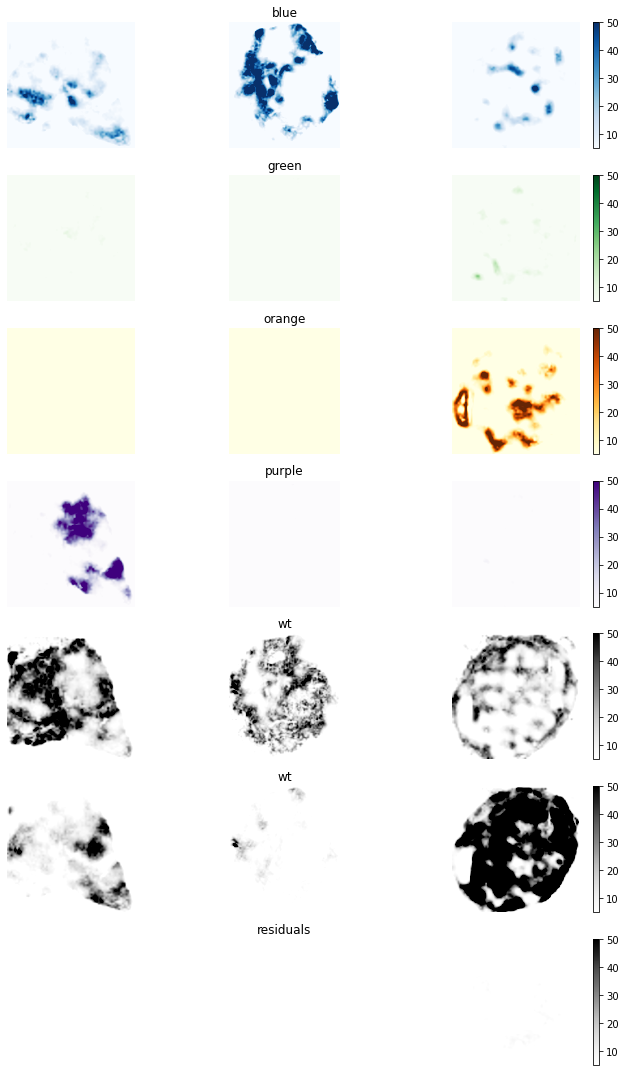

In [13]:
from matplotlib.colors import ListedColormap

alphas = np.concatenate((np.abs(np.linspace(0, 0, 256 - 200)), np.abs(np.linspace(0, 1.0, 256 - 56))))
N = 256

vals = np.ones((N, 4))
vals[:, 0] = np.linspace(1, 240/256, N)
vals[:, 1] = np.linspace(1, 228/256, N)
vals[:, 2] = np.linspace(1, 66/256, N)
vals[:, 3] = alphas
YellowCM = ListedColormap(vals)

plt.figure(figsize=(20/2, 30/2))
c = 0
#names = ['grey','green', 'purple', 'magenta', 'blue', 'red', 'orange'] + n_wt * ['wt'] + n_aug *['residuals']
names = ['blue','green', 'orange', 'purple'] + n_wt * ['wt'] + n_aug *['residuals']

#names = names[1:]

cmaps = {'grey':"Greys", 'green':"Greens", 'purple':"Purples",'magenta':"RdPu",'blue':"Blues",'red':"Reds",'orange':"YlOrBr",'wt':"Greys", 'residuals':"Greys"}
for i, ide in enumerate(np.arange(n_factors+n_aug)):
    for s in range(n_samples):
        plt.subplot(n_factors+n_aug,n_samples,c+1)
        #plt.imshow(resized_img_list[s])
        plt.imshow(cv2.resize((np.percentile(samples_hierarchical_errosion['F_{}'.format(s)][:,:,ide] * samples_hierarchical_errosion['lm_n_{}'.format(s)][:,:], 50, axis=0) ).reshape(*sample_dims[s]).T[::-1, :], tuple(np.array(sample_dims[s])*4)),
                   cmap=plt.get_cmap(cmaps[names[ide]]), vmin=5, vmax=50)
        plt.gca().axis('off')
        if s == 1:
            plt.title(names[ide])
        c += 1
    plt.colorbar()
        
plt.rcParams['figure.facecolor'] = 'w'
plt.tight_layout()
plt.show()

### Plot maps 

Maps of the most prevalent clone projected on the DAPI image (reported if
cancer cell fraction > 25% (> 15% for lymph node) and inferred local cell density > 300 cells/mm$^2$), and frequency plots of local, mean
cancer (coloured areas) and non-cancer (white) composition, corresponding to horizontal dashed
lines.

In [14]:
from scipy.interpolate import make_interp_spline, BSpline
from matplotlib.cm import get_cmap

def plot_density_stacked(sampleID, site, save=False, ax=None, flipped=False, rescale_y=1):
    names = ['blue','green', 'orange', 'purple', 'grey', 'wt']
    SampleID = sampleID
    site = site
    if flipped:
        site = -site
    grid_mm2 = (Sample.get_img_size(mut_sample_list[SampleID].image)[0] / sample_dims[SampleID][0])**2 / 1e6
    data = samples_hierarchical_errosion['F_{}'.format(sampleID)][:,:,:].reshape(300, *sample_dims[sampleID], 7)[:, ::,-site,:] *\
           cells_counts[sampleID].reshape(sample_dims[sampleID])[None, ::,-site, None] / grid_mm2
    data = np.concatenate([data[:,:,[0,1,2,3, 5]], data[:,:,[4]].sum(axis=2)[:,:,None]], axis=2)

    CI = (2.5, 97.5)
    color_list = [get_cmap(cmaps[name])(150) for name in names]
    color_list[-2] = get_cmap(cmaps[names[-2]])(50)
    line_id_list = [0, 1, 2, 3, 4, 5]
    #1e3 / 0.325 / 15
    xold = np.linspace(0, sample_dims[SampleID][0],sample_dims[SampleID][0])
    xnew = np.linspace(0, (sample_dims[SampleID][0]), 5000)

    lines_smooth = []
    for i, idx in enumerate(line_id_list): 
        line = data.mean(axis=0)[:,idx].T
        line_low = np.percentile(data, CI[0], axis=0)[:,idx].T
        line_up = np.percentile(data, CI[1], axis=0)[:,idx].T

        spl_line = make_interp_spline(xold, line, k=2)
        line_smooth = spl_line(xnew)
        line_smooth[line_smooth < 0] = 0
        lines_smooth.append(line_smooth)

    cum = np.zeros(lines_smooth[0].shape)
    if ax is not None:
        for i in range(len(line_id_list)-1):
            ax.fill_between(xnew*rescale_y, cum, cum + lines_smooth[i], color=color_list[i], alpha=1)
            cum += lines_smooth[i]
        ax.plot(xnew*rescale_y, cum + lines_smooth[i+1], color='black', alpha=1)


        ax.set_xlim(-1)
        ax.set_ylim(0, 2000)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.get_xaxis().set_visible(False)
    else:
        for i in range(len(line_id_list)-1):
            plt.fill_between(xnew*rescale_y, cum, cum + lines_smooth[i], color=color_list[i], alpha=1)
            cum += lines_smooth[i]
        plt.plot(xnew*rescale_y, cum + lines_smooth[i+1], color='black', alpha=1)


        plt.xlim(-1)
        plt.ylim(0, 2000)

        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['bottom'].set_visible(False)
        plt.gca().get_xaxis().set_visible(False)
    #plt.savefig(f'./images/2085-{SampleID}_line_{site}.pdf'.format(i))
    #plt.show()


In [15]:
stackplot_params = {0: [21, 50, 55], 1:[14, 38, 55], 2:[10, 25, 40]}

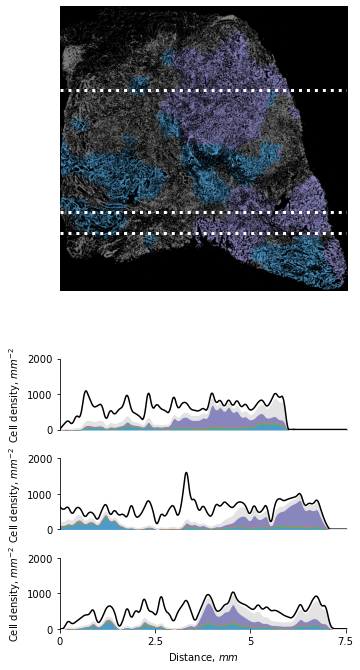

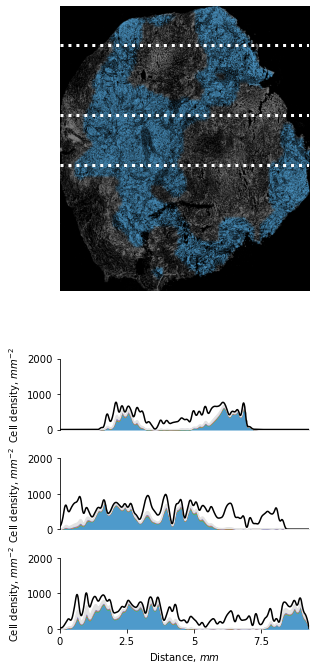

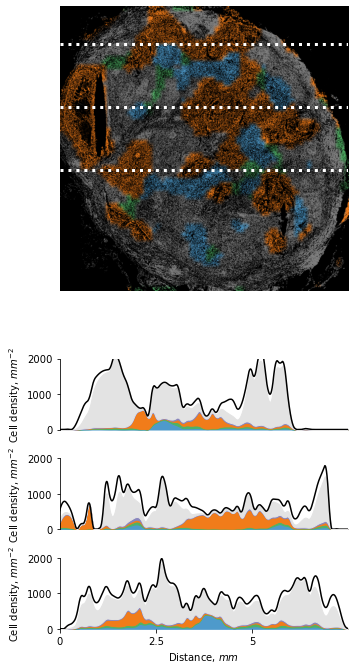

In [16]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42


def format_number(x, dec=1):
    x = float(x)
    if x % 1 == 0:
        return int(x)
    else:
        return round(x, dec)
    

from matplotlib.cm import get_cmap
from matplotlib.ticker import FormatStrFormatter, FuncFormatter


fixed_y_gridsize = np.array([[int(x) for x in list(mut_sample_list[0]._scaffold_image.shape)[::-1]][1]]+ [300]*3)
fixed_y_size = fixed_y_gridsize.sum()/300

pixel2um = 0.325


ids2plot = [0,1,2]    

fixed_y_gridsize = [np.array([[int(x) for x in list(mut_sample_list[0]._scaffold_image.shape)[::-1]][1]] + [300]*len(stackplot_params[k])) for k in ids2plot]
fixed_y_size = [x.sum()/300 for x in fixed_y_gridsize]

pixel2um = 0.325
grid_mm2 = (Sample.get_img_size(mut_sample_list[0].image)[0] / sample_dims[0][0])**2 / 1e6

cmaps = {'grey':"Greys", 'green':"Greens", 'purple':"Purples",'magenta':"RdPu",'blue':"Blues",'red':"Reds",'orange':"YlOrBr",'wt':"Greys", 'residuals':"Greys"}

names = ['blue','green', 'orange','purple'] + 2 * ['wt']

c = [get_cmap(cmaps[n])(150) for n in names]
#c[0] = get_cmap("cool")(10)
F = [samples_hierarchical_errosion[f'F_{s}'].mean(0).reshape(*sample_dims[s],-1) for s in range(n_samples)]
Lm = [samples_hierarchical_errosion[f'lm_n_{s}'].mean(0).reshape(*sample_dims[s]) for s in range(n_samples)]
Fmap = [(f[:,:,:n_factors-2]).argmax(2) for f in F]
Fn = [((fl[0][:,:,n_factors-2:]).sum(2) > [0.75, 0.75, 0.85][i]) | (cv2.blur(fl[1],(3,3)) / grid_mm2 < 100) for i, fl in enumerate(zip(F, Lm))]
n = [samples_hierarchical_errosion['lm_n_{}'.format(s)].mean(0).reshape(*sample_dims[s]).T[::-1, :] for s in range(n_samples)]
for ind, i in enumerate(ids2plot):
    img = mut_sample_list[i]._scaffold_image #tifffile.imread(mut_sample_list[i].image)
    s = img.shape
    s = tuple([int(x) for x in list(s)[::-1]])
    p35, p90 = np.percentile(img, (15, 80))
    processed_img = exposure.rescale_intensity(img, in_range=(p35, p90))
    b = cv.resize(processed_img, s)[::-1,:]/255.
    
    
    b = np.maximum(np.minimum(b,1),0)
    Fc = np.array([c[int(i)] for i in Fmap[i].flatten()]).reshape((*Fmap[i].shape,-1)).transpose((1,0,2))[::-1,:,:3]
    Fc[Fn[i].T[::-1,:],:]=0.5
    
    scale = s[0]/Fc.shape[1]
    scaffold_image_rescale = 15
    x_axis_rescale = (fixed_y_gridsize[ind][0]) / s[1] * s[0] / 300
 
    fig, axs = plt.subplots(fixed_y_gridsize[ind].size, 1, figsize=(x_axis_rescale, fixed_y_size[ind]*1.5), gridspec_kw={'height_ratios': fixed_y_gridsize[ind]}, sharex=True)
    #axs[0].plot([b.shape[1]*0.9 - 2.5e3 / pixel2um / scaffold_image_rescale, b.shape[1]*0.9], [b.shape[0]*0.95, b.shape[0]*0.95], color='white', lw=5)
    
    
    if i == 2:
        axs[0].imshow((cv.resize(Fc, s) * b.reshape(*b.shape,1))[::-1])#, alpha=n[0]/n[0].max())
        flipped = True
    else:
        axs[0].imshow(cv.resize(Fc, s) * b.reshape(*b.shape,1))
        flipped = False
    axs[0].axis('off')
    for sect in range(fixed_y_gridsize[ind].size - 1):
        axs[0].axhline((stackplot_params[i][sect]-1) * (s[1] / sample_dims[i][1]), linestyle='dotted', lw=3, color='white')
        plot_density_stacked(i, stackplot_params[i][sect], ax=axs[sect+1], flipped=flipped, rescale_y=scale)
        axs[sect+1].set_ylabel('Cell density, $mm^{-2}$')
    axs[-1].set_xticks(np.arange(0, s[0], 2.5 / (scaffold_image_rescale * 0.325 / 1e3)))
    xticklabels = np.arange(0, s[0] * scaffold_image_rescale * 0.325 / 1e3, 2.5)
    xticklabels = [format_number(x) for x in xticklabels]
    axs[-1].set_xticklabels(xticklabels)
    axs[-1].set_xlabel('Distance, $mm$')
    axs[-1].get_xaxis().set_visible(True)
    plt.xlim(0, s[0])
    #plt.savefig(f'./images/3068-{["d","a","e"][i]}_stacked_densities.pdf'.format(i), dpi=300)
    plt.show()

# Expression analysis

Knowing spatial cell density distribution of clones we attempt to characterise the clones phenotypically. There are two characteristics we use -- nuclei morphology and <it>in situ</it> sequencing expression signals. In both cases we characterise the whole region of high clone abundance. It is important to note that we do not distinguish cancer clone cells from any other type of cells and characterise selected location as a whole. The minimal unit of region is the grid tile. 

## Solid (orange) and diffuse (blue, green) clones in Lymph node - PD14780e 

For a lymph node sample PD14780e, due to a large difference between solid and diffuse clones we considered regions in the top 20th percentile of the respective clone abundance on the whole slide. To avoid double assignment of regions we excluded intersecting ones.

#### Construct data

 15%|█▌        | 10/66 [00:00<00:00, 98.85it/s]

Some of the points were out of bound


100%|██████████| 66/66 [00:00<00:00, 79.17it/s]


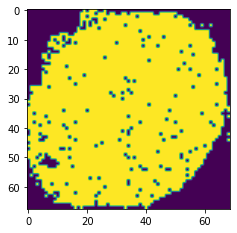

 17%|█▋        | 11/66 [00:00<00:00, 97.77it/s]

Some of the points were out of bound


100%|██████████| 66/66 [00:00<00:00, 74.49it/s]


In [17]:
samples_id = [2]
factors_id = [0,1]

n_samples = len(samples_id)
n_factors = len(factors_id)

mask_expimm = []
scale = 3
for i in samples_id:
    exp_sample_list[i].data_to_grid(scale_factor=scale, probability=0.6)
    imm_sample_list[i].data_to_grid(scale_factor=scale, probability=0.6)
    t_exp = np.array([s for s in exp_sample_list[i].gene_grid.values()]).sum(0)
    t_imm = np.array([s for s in imm_sample_list[i].gene_grid.values()]).sum(0)
    
    mask_infisiable_expimm = (exp_sample_list[i].gene_grid['infeasible']/t_exp < 0.1) * \
    (imm_sample_list[i].gene_grid['infeasible']/t_imm < 0.1) * (exp_sample_list[i].gene_grid['RAD51'] < 1)

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,2)
    plt.imshow(mask_infisiable_expimm.T[::-1,:])
    plt.show()
    mask_expimm.append(mask_infisiable_expimm.flatten())

# renaming inconsitent genes 
for i in samples_id:
    exp_sample_list[i].data_to_grid(scale_factor=scale, probability=0.6)
    imm_sample_list[i].data_to_grid(scale_factor=scale, probability=0.6)
    if 'Oct-04' in exp_sample_list[i].gene_grid.keys():
        exp_sample_list[i].gene_grid['OCT-4'] = exp_sample_list[i].gene_grid.pop('Oct-04')
        exp_sample_list[i].genes[np.where(exp_sample_list[i].genes == 'Oct-04')] = 'OCT-4'

    
imm_genes = np.concatenate([imm_sample_list[0].genes[:-4], np.array(['perforin'])])
exp_genes = exp_sample_list[0].genes[:-3]


n_imm_genes = len(imm_genes)
n_exp_genes = len(exp_genes)

n_factors_bassis=5
subclone_proportions = [np.stack([samples_hierarchical_errosion[f'f_f_{i}_{s}'] for i in range(n_factors_bassis)], axis=2) for s in samples_id]

disperesed_subcl = softmax(subclone_proportions[0], axis=2)[:,:,:2].sum(axis=2).mean(axis=0)
red_subcl = softmax(subclone_proportions[0], axis=2)[:,:,2].mean(axis=0)

disperesed_subcl_selected = disperesed_subcl > np.percentile(disperesed_subcl, 80)
red_subcl_selected =  red_subcl > np.percentile(red_subcl, 80)

disperesed_subcl_selected *= np.logical_not(disperesed_subcl_selected * red_subcl_selected)
red_subcl_selected *= np.logical_not(disperesed_subcl_selected * red_subcl_selected)

subclone_means = [np.zeros((subclone_proportions[s][:,:,:].shape[1], 2)) for s in range(n_samples)]

for s in range(n_samples):
    subclone_means[s][disperesed_subcl_selected,0] = 1.
    subclone_means[s][red_subcl_selected,1] = 1.


exp_iss_data = [np.transpose(np.array([exp_sample_list[i].gene_grid[k] for k in exp_genes]), [1,2,0]).reshape(-1, n_exp_genes) for i in samples_id]
imm_iss_data = [np.transpose(np.array([imm_sample_list[i].gene_grid[k] for k in imm_genes]), [1,2,0]).reshape(-1, n_imm_genes) for i in samples_id]

tiles_axes = [exp_sample_list[i].tile_axis for i in samples_id]

exp_cells_counts = [exp_sample_list[i].cell_grid.flatten() for i in samples_id]
imm_cells_counts = [imm_sample_list[i].cell_grid.flatten() for i in samples_id]
expimm_masks = [mask_expimm[i] for i in range(n_samples)]

sample_dims = [(int(tiles_axes[i][0][-1]+1), int(tiles_axes[i][1][-1]+1)) for i in range(n_samples)]


n_aug= 0

sample_separate_flag = True


In [18]:
mask_expimm[0] *= disperesed_subcl_selected + red_subcl_selected

### Define and run model

The essential idea behind the expression model is similar to the one we used in spatial mapping. ISS records a series of fluorescent spot, which are decoded into a set of barcodes corresponding to each of the targeted gene. Here we also represent counts of probes by a three dimensional array $\mathbf{D} \in \mathbb{N}^{|g|\times|x|\times|y|}$, where $g$ refers to the gene and $x$ and $y$ are coordinates on the grid.

The expected number of ISS signals is decomposed into maps of $s$ clone specific regions $\mathbf{M} \in \mathbb{R}_{\{0,1\}}^{|x|\times|y|\times|s|}$ each with a distinct expression pattern $\mathbf{F} \in \mathbb{R}_{+}^{|s|\times|g|}$,

$$
    \mathbb{E}[\mathbf{D}] \approx \mathbf{M} \times \mathbf{F} = \sum_{s \in \text{subclones}} \mathbf{G}_{\cdot, s} \mathbf{M}_{s, \cdot, \cdot}
$$

However, here clone specific region matrix $\mathbf{M}$ is fixed. It is encoded as indicator function over grid tiles $i$ belonging to a region $R$ of respective clone $s$

For more details see Suppl. Materials 

In [ ]:
with pm.Model() as model_exp_bi_prior:
    
    r_mu_exp = [pm.Gamma(f'r_mu_exp_{s}', mu=0.5, sigma=1, shape=(n_exp_genes, n_factors)) for s in range(n_samples)]
    r_mu_imm = [pm.Gamma(f'r_mu_imm_{s}', mu=0.5, sigma=1, shape=(n_imm_genes, n_factors)) for s in range(n_samples)]

    r_xi_exp = [pm.Gamma('r_xi_exp_{}'.format(s), mu=0.5, sigma=1, shape=n_exp_genes) for s in range(n_samples)]
    r_xi_imm = [pm.Gamma('r_xi_imm_{}'.format(s), mu=0.5, sigma=1, shape=n_imm_genes) for s in range(n_samples)]


    lm_n_exp = [pm.Gamma('lm_n_exp_{}'.format(s), mu=50, sigma=100, shape=len(exp_cells_counts[s])) for s in range(n_samples)]
    pois_n_exp = [pm.Poisson('n_exp_{}'.format(s), lm_n_exp[s], observed=exp_cells_counts[s]) for s in range(n_samples)]  
    lm_n_imm = [pm.Gamma('lm_n_imm_{}'.format(s), mu=50, sigma=100, shape=len(imm_cells_counts[s])) for s in range(n_samples)]
    pois_n_imm = [pm.Poisson('n_imm_{}'.format(s), lm_n_imm[s], observed=imm_cells_counts[s]) for s in range(n_samples)]  

    prior_proportions = [subclone_means[s] for s in range(n_samples)]    
    
    F = [pm.Deterministic('F_{}'.format(s), theano.shared(prior_proportions[s])) for s in range(n_samples)] #[pm.Deterministic('F_{}'.format(s), tt.exp(F_pri[s] / 2) / tt.exp(F_pri[s] / 2).sum(axis=1)[:,None]) for s in range(n_samples)]
    
    theta_E_exp = [pm.Deterministic('theta_E_exp_{}'.format(s), tt.dot(F[s][:,:], r_mu_exp[s].T)) for s in range(n_samples)]
    theta_E_imm = [pm.Deterministic('theta_E_imm_{}'.format(s), tt.dot(F[s][:,:], r_mu_imm[s].T)) for s in range(n_samples)]
    lm_exp = [lm_n_exp[s][:, np.newaxis] * theta_E_exp[s] + r_xi_exp[s][None, :] for s in range(n_samples)]
    lm_imm = [lm_n_imm[s][:, np.newaxis] * theta_E_imm[s] + r_xi_imm[s][None, :] for s in range(n_samples)]
    
    o_exp = pm.Gamma('o_exp', mu=100, sd=10, shape=n_exp_genes)
    o_imm = pm.Gamma('o_imm', mu=100, sd=10, shape=n_imm_genes)

    expression_genes_exp = [pm.NegativeBinomial('exp_genes_{}'.format(s), mu = lm_exp[s][expimm_masks[s],:], alpha=o_exp, observed=exp_iss_data[s][expimm_masks[s],:]) for s in range(n_samples)]
    expression_genes_imm = [pm.NegativeBinomial('imm_genes_{}'.format(s), mu = lm_imm[s][expimm_masks[s],:], alpha=o_imm, observed=imm_iss_data[s][expimm_masks[s],:]) for s in range(n_samples)]


In [ ]:
np.random.seed(1234) 
pm.set_tt_rng(1234)

with model_exp_bi_prior :
    advi = pm.ADVI()
    approx_exp_bi_prior = advi.fit(n=15000, obj_optimizer=pm.adam(learning_rate=0.01))
    


In [19]:
#with open('./data/3608_approx_redVSdisperced_03-24.pkl', 'wb') as file:
#    pkl.dump(approx_exp_bi_prior, file)
with open('../pymc_model/data/3608_approx_redVSdisperced_03-24.pkl', 'rb') as file:
    approx_exp_bi_prior = pkl.load(file)

### Extract inferred parameters 

In [20]:
np.random.seed(192)
means = approx_exp_bi_prior.bij.rmap(approx_exp_bi_prior.mean.eval())
rho = approx_exp_bi_prior.rho.eval()
sds = approx_exp_bi_prior.bij.rmap(np.log(1 + np.exp(rho)))

if sample_separate_flag:
    E_data_mean = np.concatenate([np.stack([means[f'r_mu_exp_{s}_log__'] for s in range(n_samples)], axis=1),
                                  np.stack([means[f'r_mu_imm_{s}_log__'] for s in range(n_samples)], axis=1)], axis=0)
    E_data_sds = np.concatenate([np.stack([sds[f'r_mu_exp_{s}_log__'] for s in range(n_samples)], axis=1),
                                  np.stack([sds[f'r_mu_imm_{s}_log__'] for s in range(n_samples)], axis=1)], axis=0)

E_data = np.transpose(np.exp(np.random.normal(E_data_mean, E_data_sds, size=(100000, *E_data_mean.shape))), axes=(0,1,3,2))

E_names = np.concatenate([exp_genes, imm_genes])
E_pannel_from = np.array(['exp'] * n_exp_genes  + ['imm'] * n_imm_genes)
E_pannel_color = np.array(['orange'] * n_exp_genes  + ['skyblue'] * n_imm_genes)

exp_signal_counts = np.array([[(exp_iss_data[s][subclone_means[s][:,i] == 1]).sum(axis=0).astype(int) for i in range(2)] for s in range(1)]).T
imm_signal_counts = np.array([[(imm_iss_data[s][subclone_means[s][:,i] == 1]).sum(axis=0).astype(int) for i in range(2)] for s in range(1)]).T

exp_cell_counts = np.array([[(exp_cells_counts[s][subclone_means[s][:,i] == 1]).sum(axis=0).astype(int) for i in range(2)] for s in range(1)]).T
imm_cell_counts = np.array([[(imm_cells_counts[s][subclone_means[s][:,i] == 1]).sum(axis=0).astype(int) for i in range(2)] for s in range(1)]).T

signal_counts = np.concatenate([exp_signal_counts, imm_signal_counts], axis=0)
nucl = np.concatenate([exp_cell_counts[None,:,:], imm_cell_counts[None,:,:]], axis=0)
tiles = np.array([subclone_means[0].sum(axis=0) for i in range(1)])
signal_counts_per_nucl = np.concatenate([exp_signal_counts/exp_cell_counts[None,:,:], imm_signal_counts/imm_cell_counts[None,:,:]], axis=0)
cell_counts = np.stack([exp_cell_counts, imm_cell_counts])


#chagne gene names in plots
gene_name2good = {'PTPRC':'CD45', 'CD274':'PD-L1', 'Ki-67':'MKI67'}
for k in gene_name2good.keys():
    E_names[np.where(E_names == k)] = gene_name2good[k]

#remove PTPRC_trans5

ptprc_trans5_loc = np.where(E_names == 'PTPRC_trans5')[0]

E_data = np.delete(E_data, ptprc_trans5_loc, axis=1)
E_names = np.delete(E_names, ptprc_trans5_loc)
E_pannel_from = np.delete(E_pannel_from, ptprc_trans5_loc)
E_pannel_color = np.delete(E_pannel_color, ptprc_trans5_loc)
signal_counts = np.delete(signal_counts, ptprc_trans5_loc, axis=0)
signal_counts_per_nucl = np.delete(signal_counts_per_nucl, ptprc_trans5_loc, axis=0)

In [21]:
sample_names = ['e']
data_dict = {sample_names[i]:E_data[:,:,:,n] for i, n in enumerate([0])}

subclone_progression_absolute = {}
subclone_raw_data = {}
subclone_countspernucl_data = {}
subclone_tiles = {}
subclone_nuclei = {}

In [22]:
subclone_progression_absolute['MET-O-e'] = data_dict['e'][:,:,1]
subclone_progression_absolute['MET-B|G-e'] = data_dict['e'][:,:,0]


subclone_raw_data['MET-B|G-e'] = signal_counts[:,0,0]
subclone_raw_data['MET-O-e'] = signal_counts[:,1,0]

subclone_countspernucl_data['MET-B|G-e'] = signal_counts_per_nucl[:,0,0]
subclone_countspernucl_data['MET-O-e'] = signal_counts_per_nucl[:,1,0]

subclone_tiles['MET-B|G-e'] = tiles[:,0]
subclone_tiles['MET-O-e'] = tiles[:,1]

subclone_nuclei['MET-B|G-e'] = nucl[:,0]
subclone_nuclei['MET-O-e'] = nucl[:,0]

#### Set functional gene colour

In [23]:
exp_gene_groups = pd.read_csv('../pymc_model/data/exp_genes_groups.csv')
imm_gene_groups = pd.read_csv('../pymc_model/data/imm_genes_group.csv')
OncotypeDX = exp_gene_groups[(exp_gene_groups.OncotypeDX == 'down') | (exp_gene_groups.OncotypeDX == 'up')]

imm_gene2type = {imm_gene_groups['ISS target name '].values[i]:imm_gene_groups['Group'].values[i] for i in range(imm_gene_groups.shape[0])}
exp_gene2type = {exp_gene_groups['ISS Target name'].values[i]:exp_gene_groups['Group'].values[i] for i in range(exp_gene_groups.shape[0])}
exp_gene2oncotype = {OncotypeDX['ISS Target name'].values[i]:OncotypeDX['OncotypeDX'].values[i] for i in range(OncotypeDX.shape[0])}

exp_gene2oncotype['HER2'] = exp_gene2oncotype.pop('ERBB2')

def gene2funcgroup(gene, pannel):
    if pannel == 'imm':
        try:
            return imm_gene2type[gene]
        except KeyError:
            return None
    elif  pannel == 'exp':
        try:
            return exp_gene2type[gene]
        except KeyError:
            return None
    else:
        raise KeyError('either exp or imm')

def gene2funccolor(gene, pannel, default_color='lightgrey'):
    colors = {'Bcell':'orange',
              #'CD8_Tcell':'steelblue',
              #'CD8_naive':'lightskyblue', 
          #'CD8_cytotoxic':'magenta',#, 'CD8_naive':'forestgreen', 
          #'DC': 'purple',
          #'fibroblast':'gold','Fibroblast markers':'gold',
          #'hypoxia_angiogenesis':'red','Angiogenesis/growth factors':'red',
          #'immune_tolerance': 'skyblue',
          #'NK':'forestgreen',
          'macrophage':'skyblue', 'Macrophage markers':'skyblue',
          'monocyte':'tomato',
          #'pan_immune_cell_marker':'black', 'Lymphocyte marker':'black',
          #'proliferation': 'orangered', 'Proliferation':'violet', 'HER2':'violet',
          #'Tcell':'brown', 'Tcell_CD4':'brown',
          #'Treg': 'darkviolet'}
          #'Stemness/differentiation': 'darkgreen'}
             }
    
    group = gene2funcgroup(gene, pannel)
    try:
        return colors[group]
    except KeyError:
        return default_color

    
oncotypes = {'GRB7':'grb7' , 'HER2':'grb7',
             'ER':'er', 'PR':'er', 'BCL2':'er', 'SCUBE2':'er',
             'BIRC5':'proliferation', 'MKI67':'proliferation', 'MYBL2':'proliferation', 'CCNB1':'proliferation', 'STK15':'proliferation',
             'CTSL2': 'invasion', 'MMP11': 'invasion'}

def gene2oncocolor(gene, default_color='lightgrey'):
    color={'grb7': 'forestgreen', 'er':'dodgerblue', 'proliferation':'darkorange', 'invasion':'red'}
    try:
        oncotype = oncotypes[gene]
        return color[oncotype]
    except KeyError:
        return default_color
    

In [24]:
dat = data_dict['e'][:,:,1] / data_dict['e'][:,:,0]
dat = np.log10(dat)
p_vals = pplr(data_dict['e'][:,:,0], data_dict['e'][:,:,1], 1)
p_vals = bonferonni(p_vals, m=len(p_vals)*2)


### Differential expression between DCIS-green and DCIS-orange
<b>Fig. 4. Tracing aggressive disease in a lymph node metastasis.</b>

<b>(F)</b> Barplots of subclone
specific gene expression fold changes in PD14780e (orange versus blue/green aggregated signals)
for immune and oncology panels ordered by PPLR and direction of change. Genes with significant expression difference (PPLR after Bonferroni correction < 0.01) are annotated.

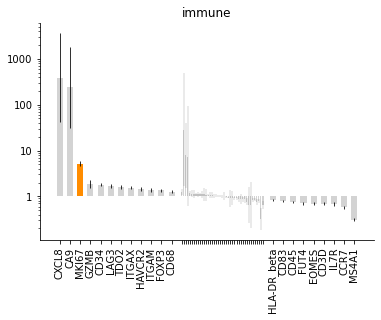

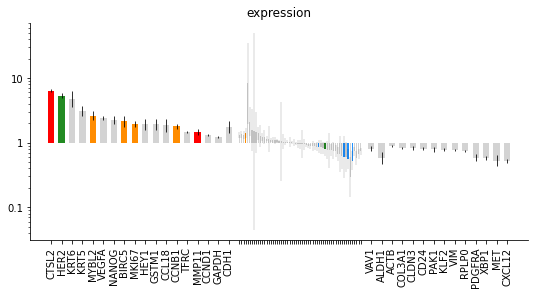

In [25]:
from matplotlib.ticker import MultipleLocator, FixedLocator, FuncFormatter
###### Locators for Y-axis
# set tickmarks at multiples of 1.
majorLocator = MultipleLocator(1.)
# create custom minor ticklabels at logarithmic positions
ra = np.array([ [n+(1.-np.log10(i))]  for n in range(-5,5) for i in [2,3,4,5,6,7,8,9][::-1]]).flatten()*-1.
minorLocator = FixedLocator(ra)
###### Formatter for Y-axis (chose any of the following two)
# show labels as powers of 10 (looks ugly)
majorFormatter= FuncFormatter(lambda x,p: "{:.4g}".format(10**x) ) 
# or using MathText (looks nice, but not conform to the rest of the layout)
#majorFormatter= FuncFormatter(lambda x,p: r"$10^{"+"{x:d}".format(x=int(x))+r"}$" ) 


percentiles_dat = [np.percentile(dat, pct, axis=0) for pct in [5,50,95]]

for pannel_id in range(2):
    subset = np.where(E_pannel_from == ['imm', 'exp'][pannel_id])[0]
    sub_percentiles_dat = [percentiles_dat[i][subset] for i in range(3)]
    p_vals_sub = p_vals[subset]
    ranks = -np.round(1/p_vals_sub * np.sign(sub_percentiles_dat[1]),1)
    order = []
    for r in np.unique(ranks):
        ranked_order = np.where(ranks == r)[0]
        magnitude_order = list(ranked_order[np.argsort((sub_percentiles_dat[1])[np.where(ranks == r)[0]])[::-1]]) 
        order += magnitude_order  
        
    boundaries = [0] + list(np.cumsum([len(np.where(ranks == r)[0]) for r in np.unique(ranks)]))
    boundaries_pval = np.array([0]+list([p_vals_sub[np.where(ranks == r)[0]][0] for r in np.unique(ranks)]))
    
    p_val_th = 0.01
    #color = [['darkgrey' if i < p_val_th else 'lightgrey' for i in p_vals[s][gene_filtered][subset][order]] for s in range(2)]
    gene_names = E_names[subset][order]
    if pannel_id == 1:
        #color = ['dimgrey', 'lightgrey']
        color = [gene2oncocolor(gene) for gene in gene_names]
    else:
        color = [gene2oncocolor(gene) for gene in gene_names]
    bpv = np.array(boundaries)[np.where(np.diff(boundaries_pval < p_val_th))[0]]
    xposdiff = np.ones(len(order))
    squeezed = 0.2
    
    if len(bpv) == 2:
        xposdiff[bpv[0]+1:bpv[1]] = squeezed
        xpos = np.cumsum(xposdiff)
        widths = xposdiff.copy()
        widths[bpv[0]] = squeezed
    elif len(bpv) == 1:
        if (boundaries_pval < p_val_th)[0]:
            xposdiff[bpv[0]+1:] = squeezed
            xpos = np.cumsum(xposdiff)
            widths = xposdiff.copy()
            widths[bpv[0]] = squeezed
        else:
            xposdiff[:bpv[0]-1] = squeezed
            xpos = np.cumsum(xposdiff)
            widths = xposdiff.copy()
    elif len(bpv) == 0:
        xpos = np.cumsum(xposdiff)
        widths = xposdiff.copy()
        
    
    for i in range(3):
        sub_percentiles_dat[i] = sub_percentiles_dat[i][order]
        
    
    plt.figure(figsize=(xpos[-1] * 0.2,4))
    plt.bar(xpos, sub_percentiles_dat[1], yerr=[np.abs(sub_percentiles_dat[0]-sub_percentiles_dat[1]),
                                                       np.abs(sub_percentiles_dat[2]-sub_percentiles_dat[1])], width=0.6*widths,
                       color=color, error_kw={'linewidth':widths*1, 'alpha':0.8})

    plt.gca().set_xticks(xpos)
    gene_names[widths == squeezed] = ''
    plt.gca().set_xticklabels(gene_names, rotation=90)
    plt.gca().set_title(['immune', 'expression'][pannel_id])
    plt.xlim(xpos[0]-2,xpos[-1]+2)
    #plt.ylim(-1.5, 1.5)
    plt.gca().yaxis.set_major_locator(majorLocator)
    plt.gca().yaxis.set_minor_locator(minorLocator)
    plt.gca().yaxis.set_major_formatter(majorFormatter)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    #plt.savefig(f'./images/3068_BlueGreenVsOrange_{["imm", "exp"][pannel_id]}_bars_sample_E.pdf'.format(i))
    plt.show()

## Blue-Invasive and Purple-Invasive subclones in sample 

For pure invasive sample PD14780a, we selected regions with the highest abundance of the respective clone

100%|██████████| 66/66 [00:00<00:00, 169.19it/s]


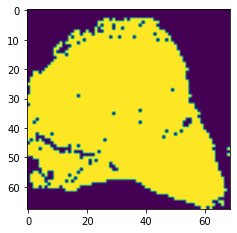

100%|██████████| 66/66 [00:00<00:00, 195.52it/s]


In [27]:
samples_id = [0]
factors_id = [0,3]

n_samples = len(samples_id)
n_factors = len(factors_id)
n_factors_bassis=5


mask_expimm = []
scale = 3
for i in samples_id:
    exp_sample_list[i].data_to_grid(scale_factor=scale, probability=0.6)
    imm_sample_list[i].data_to_grid(scale_factor=scale, probability=0.6)
    t_exp = np.array([s for s in exp_sample_list[i].gene_grid.values()]).sum(0)
    t_imm = np.array([s for s in imm_sample_list[i].gene_grid.values()]).sum(0)
    
    mask_infisiable_expimm = (exp_sample_list[i].gene_grid['infeasible']/t_exp < 0.1) * (imm_sample_list[i].gene_grid['infeasible']/t_imm < 0.1)

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,2)
    plt.imshow(mask_infisiable_expimm.T[::-1,:])
    plt.show()
    mask_expimm.append(mask_infisiable_expimm.flatten())

# renaming inconsitent genes 
for i in samples_id:
    exp_sample_list[i].data_to_grid(scale_factor=scale, probability=0.6)
    imm_sample_list[i].data_to_grid(scale_factor=scale, probability=0.6)
    if 'Oct-04' in exp_sample_list[i].gene_grid.keys():
        exp_sample_list[i].gene_grid['OCT-4'] = exp_sample_list[i].gene_grid.pop('Oct-04')
        exp_sample_list[i].genes[np.where(exp_sample_list[i].genes == 'Oct-04')] = 'OCT-4'

    
imm_genes = np.concatenate([imm_sample_list[0].genes[:-4], np.array(['perforin'])])
exp_genes = exp_sample_list[0].genes[:-3]


n_imm_genes = len(imm_genes)
n_exp_genes = len(exp_genes)

subclone_proportions = [np.stack([samples_hierarchical_errosion[f'f_f_{i}_{s}'] for i in range(n_factors_bassis)], axis=2) for s in samples_id]

subcl_locations = []
for s in range(n_samples):
    subcl_locations.append([])
    for i, f in enumerate(factors_id):
        subcl_locations[s].append(softmax(subclone_proportions[s], axis=2)[:,:,f].mean(axis=0))
        subcl_locations[s][i] = subcl_locations[s][i] > np.percentile(subcl_locations[s][i], 80)
    subcl_intersection = np.zeros(subcl_locations[s][0].shape) 
    for i in range(n_factors):
        subcl_intersection += subcl_locations[s][i].astype(int)
    subcl_intersection = subcl_intersection > 1
    for i in range(n_factors):
        subcl_locations[s][i] *= np.logical_not(subcl_intersection)
        

subclone_means = [np.array(subcl_locations[s]).T for s in range(n_samples)] #[subclone_proportions_wtjoined[s].mean(axis=0) for s in range(n_samples)]

exp_iss_data = [np.transpose(np.array([exp_sample_list[i].gene_grid[k] for k in exp_genes]), [1,2,0]).reshape(-1, n_exp_genes) for i in samples_id]
imm_iss_data = [np.transpose(np.array([imm_sample_list[i].gene_grid[k] for k in imm_genes]), [1,2,0]).reshape(-1, n_imm_genes) for i in samples_id]

tiles_axes = [exp_sample_list[i].tile_axis for i in samples_id]

exp_cells_counts = [exp_sample_list[i].cell_grid.flatten() for i in samples_id]
imm_cells_counts = [imm_sample_list[i].cell_grid.flatten() for i in samples_id]
expimm_masks = [mask_expimm[i] for i in range(n_samples)]

sample_dims = [(int(tiles_axes[i][0][-1]+1), int(tiles_axes[i][1][-1]+1)) for i in range(n_samples)]

n_aug= 0

sample_separate_flag = True


In [28]:
for s in range(n_samples):
    mask_expimm[s] *= subclone_means[s].sum(axis=1).astype(bool)

### Define and run expression model

In [ ]:
with pm.Model() as model_exp_bi_prior:
    
    r_mu_exp = [pm.Gamma(f'r_mu_exp_{s}', mu=0.5, sigma=1, shape=(n_exp_genes, n_factors)) for s in range(n_samples)]
    r_mu_imm = [pm.Gamma(f'r_mu_imm_{s}', mu=0.5, sigma=1, shape=(n_imm_genes, n_factors)) for s in range(n_samples)]

    r_xi_exp = [pm.Gamma('r_xi_exp_{}'.format(s), mu=0.5, sigma=1, shape=n_exp_genes) for s in range(n_samples)]
    r_xi_imm = [pm.Gamma('r_xi_imm_{}'.format(s), mu=0.5, sigma=1, shape=n_imm_genes) for s in range(n_samples)]


    lm_n_exp = [pm.Gamma('lm_n_exp_{}'.format(s), mu=50, sigma=100, shape=len(exp_cells_counts[s])) for s in range(n_samples)]
    pois_n_exp = [pm.Poisson('n_exp_{}'.format(s), lm_n_exp[s], observed=exp_cells_counts[s]) for s in range(n_samples)]  
    lm_n_imm = [pm.Gamma('lm_n_imm_{}'.format(s), mu=50, sigma=100, shape=len(imm_cells_counts[s])) for s in range(n_samples)]
    pois_n_imm = [pm.Poisson('n_imm_{}'.format(s), lm_n_imm[s], observed=imm_cells_counts[s]) for s in range(n_samples)]  

    prior_proportions = [subclone_means[s] for s in range(n_samples)]

    F = [pm.Deterministic('F_{}'.format(s), theano.shared(prior_proportions[s])) for s in range(n_samples)] #[pm.Deterministic('F_{}'.format(s), tt.exp(F_pri[s] / 2) / tt.exp(F_pri[s] / 2).sum(axis=1)[:,None]) for s in range(n_samples)]
    
    theta_E_exp = [pm.Deterministic('theta_E_exp_{}'.format(s), tt.dot(F[s][:,:], r_mu_exp[s].T)) for s in range(n_samples)]
    theta_E_imm = [pm.Deterministic('theta_E_imm_{}'.format(s), tt.dot(F[s][:,:], r_mu_imm[s].T)) for s in range(n_samples)]
    lm_exp = [lm_n_exp[s][:, np.newaxis] * theta_E_exp[s] + r_xi_exp[s][None, :] for s in range(n_samples)]
    lm_imm = [lm_n_imm[s][:, np.newaxis] * theta_E_imm[s] + r_xi_imm[s][None, :] for s in range(n_samples)]

    o_exp = pm.Gamma('o_exp', mu=100, sd=10, shape=n_exp_genes)
    o_imm = pm.Gamma('o_imm', mu=100, sd=10, shape=n_imm_genes)

    expression_genes_exp = [pm.NegativeBinomial('exp_genes_{}'.format(s), mu = lm_exp[s][expimm_masks[s],:], alpha=o_exp, observed=exp_iss_data[s][expimm_masks[s],:]) for s in range(n_samples)]
    expression_genes_imm = [pm.NegativeBinomial('imm_genes_{}'.format(s), mu = lm_imm[s][expimm_masks[s],:], alpha=o_imm, observed=imm_iss_data[s][expimm_masks[s],:]) for s in range(n_samples)]


In [ ]:
np.random.seed(1234) 
pm.set_tt_rng(1234)

with model_exp_bi_prior :
    advi = pm.ADVI()
    approx_exp_bi_prior = advi.fit(n=15000, obj_optimizer=pm.adam(learning_rate=0.01))
    

In [29]:
#with open('./data/3608_approx_BlueVSPurple_03-26.pkl', 'wb') as file:
#    pkl.dump(approx_exp_bi_prior, file)
with open('../pymc_model/data/3608_approx_BlueVSPurple_03-26.pkl', 'rb') as file:
    approx_exp_bi_prior = pkl.load(file)

In [ ]:
plt.plot(approx_exp_bi_prior.hist[1000:])
#samples_exp_bi_prior = approx_exp_bi_prior.sample(300)


### Extract inferred parameters 

In [30]:
np.random.seed(192)

means = approx_exp_bi_prior.bij.rmap(approx_exp_bi_prior.mean.eval())
rho = approx_exp_bi_prior.rho.eval()
sds = approx_exp_bi_prior.bij.rmap(np.log(1 + np.exp(rho)))

if sample_separate_flag:
    E_data_mean = np.concatenate([np.stack([means[f'r_mu_exp_{s}_log__'] for s in range(n_samples)], axis=1),
                                  np.stack([means[f'r_mu_imm_{s}_log__'] for s in range(n_samples)], axis=1)], axis=0)
    E_data_sds = np.concatenate([np.stack([sds[f'r_mu_exp_{s}_log__'] for s in range(n_samples)], axis=1),
                                  np.stack([sds[f'r_mu_imm_{s}_log__'] for s in range(n_samples)], axis=1)], axis=0)
  
E_data = np.transpose(np.exp(np.random.normal(E_data_mean, E_data_sds, size=(100000, *E_data_mean.shape))), axes=(0,1,3,2))

E_names = np.concatenate([exp_genes, imm_genes])
E_pannel_from = np.array(['exp'] * n_exp_genes  + ['imm'] * n_imm_genes)
E_pannel_color = np.array(['orange'] * n_exp_genes  + ['skyblue'] * n_imm_genes)

exp_signal_counts = np.array([[(exp_iss_data[s][subclone_means[s][:,i] == 1]).sum(axis=0).astype(int) for i in range(2)] for s in range(1)]).T
imm_signal_counts = np.array([[(imm_iss_data[s][subclone_means[s][:,i] == 1]).sum(axis=0).astype(int) for i in range(2)] for s in range(1)]).T

exp_cell_counts = np.array([[(exp_cells_counts[s][subclone_means[s][:,i] == 1]).sum(axis=0).astype(int) for i in range(2)] for s in range(1)]).T
imm_cell_counts = np.array([[(imm_cells_counts[s][subclone_means[s][:,i] == 1]).sum(axis=0).astype(int) for i in range(2)] for s in range(1)]).T

signal_counts = np.concatenate([exp_signal_counts, imm_signal_counts], axis=0)
nucl = np.concatenate([exp_cell_counts[None,:,:], imm_cell_counts[None,:,:]], axis=0)
tiles = np.array([subclone_means[0].sum(axis=0) for i in range(1)])
signal_counts_per_nucl = np.concatenate([exp_signal_counts/exp_cell_counts[None,:,:], imm_signal_counts/imm_cell_counts[None,:,:]], axis=0)
cell_counts = np.stack([exp_cell_counts, imm_cell_counts])


#chagne gene names in plots
gene_name2good = {'PTPRC':'CD45', 'CD274':'PD-L1', 'Ki-67':'MKI67'}
for k in gene_name2good.keys():
    E_names[np.where(E_names == k)] = gene_name2good[k]

#remove PTPRC_trans5

ptprc_trans5_loc = np.where(E_names == 'PTPRC_trans5')[0]

E_data = np.delete(E_data, ptprc_trans5_loc, axis=1)
E_names = np.delete(E_names, ptprc_trans5_loc)
E_pannel_from = np.delete(E_pannel_from, ptprc_trans5_loc)
E_pannel_color = np.delete(E_pannel_color, ptprc_trans5_loc)
signal_counts = np.delete(signal_counts, ptprc_trans5_loc, axis=0)
signal_counts_per_nucl = np.delete(signal_counts_per_nucl, ptprc_trans5_loc, axis=0)

In [31]:
sample_names = ['a']
data_dict = {sample_names[i]:E_data[:,:,:,n] for i, n in enumerate([0])}
# look at d and l 
data_dict = {k:data_dict[k] for k in ['a']}

In [32]:
subclone_progression_absolute['INV-P-a'] = data_dict['a'][:,:,1]
subclone_progression_absolute['INV-B-a'] = data_dict['a'][:,:,0]


subclone_raw_data['INV-B-a'] = signal_counts[:,0,0]
subclone_raw_data['INV-P-a'] = signal_counts[:,1,0]

subclone_countspernucl_data['INV-B-a'] = signal_counts_per_nucl[:,0,0]
subclone_countspernucl_data['INV-P-a'] = signal_counts_per_nucl[:,1,0]

subclone_tiles['INV-B-a'] = tiles[:,0]
subclone_tiles['INV-P-a'] = tiles[:,1]

subclone_nuclei['INV-B-a'] = nucl[:,0]
subclone_nuclei['INV-P-a'] = nucl[:,0]

In [33]:
dat = data_dict['a'][:,:,1] / data_dict['a'][:,:,0]
dat = np.log10(dat)
p_vals = pplr(data_dict['a'][:,:,0], data_dict['a'][:,:,1], 1)
p_vals = bonferonni(p_vals, m=len(p_vals)*2)




### Differential expression between INV-Blue and INV-Purple
<b>Fig. S5. Spatial evolution in an invasive cancer and lymph node metastasis</b>

<b>(D)</b> Barplot reporting expression fold change in ISS signals between the purple (838 tiles) and blue
(838 tiles) clone. Significantly altered genes are shown (PPLR after bonferroni adjustment
<=0.01).

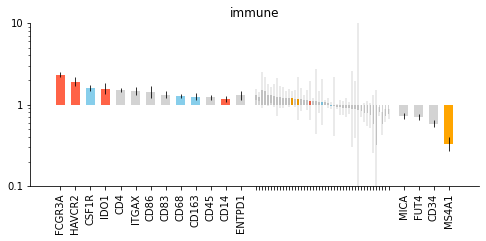

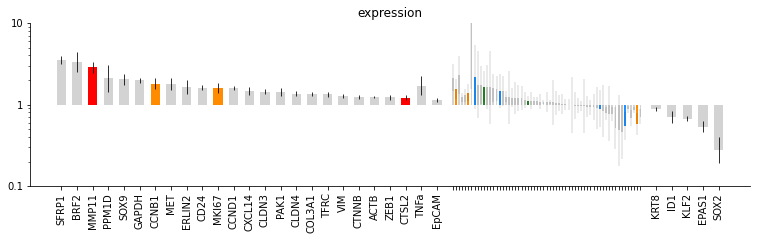

In [34]:
from matplotlib.ticker import MultipleLocator, FixedLocator, FuncFormatter
###### Locators for Y-axis
# set tickmarks at multiples of 1.
majorLocator = MultipleLocator(1.)
# create custom minor ticklabels at logarithmic positions
ra = np.array([ [n+(1.-np.log10(i))]  for n in range(-3,3) for i in [2,3,4,5,6,7,8,9][::-1]]).flatten()*-1.
minorLocator = FixedLocator(ra)
###### Formatter for Y-axis (chose any of the following two)
# show labels as powers of 10 (looks ugly)
majorFormatter= FuncFormatter(lambda x,p: "{:.3g}".format(10**x) ) 
# or using MathText (looks nice, but not conform to the rest of the layout)
#majorFormatter= FuncFormatter(lambda x,p: r"$10^{"+"{x:d}".format(x=int(x))+r"}$" ) 


percentiles_dat = [np.percentile(dat, pct, axis=0) for pct in [2.5,50,97.5]]

for pannel_id in range(2):
    subset = np.where(E_pannel_from == ['imm', 'exp'][pannel_id])[0]
    sub_percentiles_dat = [percentiles_dat[i][subset] for i in range(3)]

    ranks = -np.round(1/p_vals[subset] * np.sign(sub_percentiles_dat[1]),2)
    order = []
    for r in np.unique(ranks):
        ranked_order = np.where(ranks == r)[0]
        magnitude_order = list(ranked_order[np.argsort(sub_percentiles_dat[1][np.where(ranks == r)[0]])[::-1]]) 
        order += magnitude_order  
        
    boundaries = [0] + list(np.cumsum([len(np.where(ranks == r)[0]) for r in np.unique(ranks)]))
    boundaries_pval = np.array([0]+list([p_vals[subset][np.where(ranks == r)[0]][0] for r in np.unique(ranks)]))
    
    p_val_th = 0.01
    #color = ['darkgrey' if i < p_val_th else 'lightgrey' for i in p_vals[gene_filtered][subset][order]]
    gene_names = E_names[subset][order]
    if pannel_id == 0:
        #color = [gene2oncocolor(gene) for gene in gene_names]
        color = [gene2funccolor(gene, 'imm') for gene in gene_names]
    else:
        color = [gene2oncocolor(gene) for gene in gene_names]
    
    bpv = np.array(boundaries)[np.where(np.diff(boundaries_pval < p_val_th))[0]]
    xposdiff = np.ones(len(order))
    squeezed = 0.2
    if len(bpv) == 2:
        xposdiff[bpv[0]+1:bpv[1]] = squeezed
        xpos = np.cumsum(xposdiff)
        widths = xposdiff.copy()
        widths[bpv[0]] = squeezed
    elif len(bpv) == 1:
        if (boundaries_pval < p_val_th)[0]:
            xposdiff[:bpv[0]-1] = squeezed
            xpos = np.cumsum(xposdiff)
            widths = xposdiff.copy()
        else:
            xposdiff[bpv[0]+1:] = squeezed
            xpos = np.cumsum(xposdiff)
            widths = xposdiff.copy()
            widths[bpv[0]] = squeezed
    elif len(bpv) == 0:
        xpos = np.cumsum(xposdiff)
        widths = xposdiff.copy()
    else:
        raise IndexError('what the hell')

    for i in range(3):
        sub_percentiles_dat[i] = sub_percentiles_dat[i][order]
        
    
    plt.figure(figsize=(xpos[-1] * 0.3,3))
    plt.bar(xpos, sub_percentiles_dat[1], yerr=[np.abs(sub_percentiles_dat[0]-sub_percentiles_dat[1]),
                                                       np.abs(sub_percentiles_dat[2]-sub_percentiles_dat[1])], width=0.6*widths,
                       color=color, error_kw={'linewidth':widths*1, 'alpha':0.8})

    plt.gca().set_xticks(xpos)
    gene_names[widths == squeezed] = ''
    plt.gca().set_xticklabels(gene_names, rotation=90)
    plt.gca().set_title(['immune', 'expression'][pannel_id])
    plt.xlim(xpos[0]-2,xpos[-1]+2)
    plt.ylim(-1,1)
    plt.gca().yaxis.set_major_locator(majorLocator)
    plt.gca().yaxis.set_minor_locator(minorLocator)
    plt.gca().yaxis.set_major_formatter(majorFormatter)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    #plt.savefig(f'./images/3068_PurpleVsBlue_{["imm", "exp"][pannel_id]}_bars.pdf'.format(i))
plt.show()